In [16]:
import os

HOME = os.getcwd()
DATA = os.path.join(HOME, 'training', 'layout-analysis', 'data', 'raw-data')

In [24]:
import cv2
import pytesseract
from pytesseract import Output

# Define a function to check if an image with text is rotated
def is_image_rotated(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Use Tesseract to detect the orientation and script
    osd = pytesseract.image_to_osd(gray, output_type=Output.DICT)
    osd = pytesseract.image_to_string(gray, lang='rus')
    return osd
    
    # # Check if the image is rotated
    # rotation_angle = osd['rotate']
    # if rotation_angle != 0:
    #     return True, rotation_angle
    # else:
    #     return False, rotation_angle

# Example usage:
# rotated, angle = is_image_rotated('path_to_image.jpg')
# print(f"Is the image rotated? {rotated}, Rotation angle: {angle}")


In [34]:
for image_path in os.listdir(DATA):
    full_image_path = os.path.join(DATA, image_path)
    a = is_image_rotated(image_path=full_image_path)
    print(a)

    break

Противопоказания.

Повышенная чувствительйость к действующему веществу или к любому из
компонентов препарата.

Специфические инфекции в аноректальной области (туберкулез, сифилис,
гонорея), ветряная оспа, реакция на вакцинацию, грибковые заболевания,

воспалительные заболевания кожи лица (периоральный дерматит, розацеа),

другие бактериальные, вирусные, паразит ‚\[‚.Ё„ЁЗВЁН ые
ВАН

СОГЛАСО

Приказ Министерства здравоохранснмя 3
Рэаспублини Велаплуеть

Т ноА коожлПо!еМИНЫЦоННо «ботадаееке у -трна га жа омЫ ы ожллья та аат оЙ

поражения и атрофические изменения в област

средства, опухоли аНОРСКТЗЛЬНОЙ ЗОНЫ.

Меры предосторожности.

Лечение продолжать до исчезновения симптомов, но не более 5-7 дней.

При отсутствии эффекта необходимо пересмотреть проводимую терапию.
При применении любых глюкокортикостероидов следует помнить 0
возможности системной абсорбции.

В случае грибковых инфекций необходимо одновременно применять

местный противогрибковый препарат.

Взаимодействие с другими лекарс

In [1]:
from modules.detectors import YOLOOBBDetector
from PIL import Image
IMAGE_PATH = "training/layout-analysis/data/dataset/test/52cfd69b-11022_21_s_3.jpg"

# Load image
image = Image.open(IMAGE_PATH).convert("RGB")

# Make detection and crop keys
key_detector = YOLOOBBDetector(model_path='models/la_best.pt')
results = key_detector.predict(image)
crops = key_detector.crop_keys(image=image,
                                results=results)
cropped_table = Image.fromarray(crops['trash'])

# # Visualize detection
# key_detector.visualize_detection(results)


0: 1280x928 107.7ms
Speed: 11.5ms preprocess, 107.7ms inference, 140.8ms postprocess per image at shape (1, 3, 1280, 928)


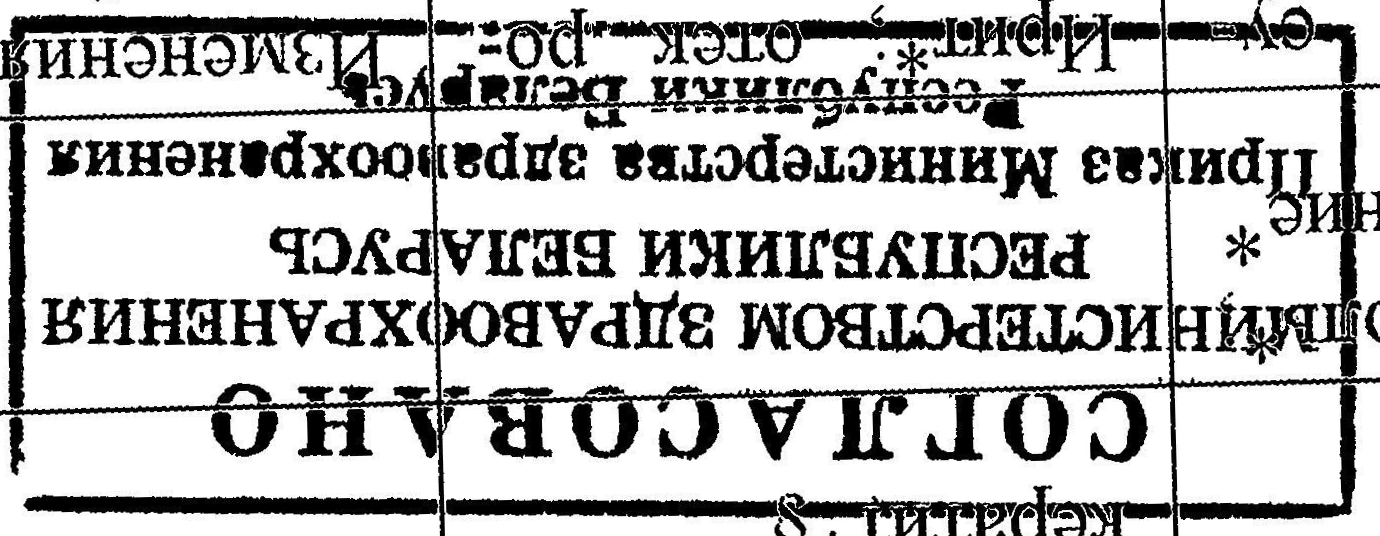

In [2]:
cropped_table

In [3]:
key_detector.visualize_detection(results)

In [7]:
from transformers import SegformerConfig

def load_model(checkpoint, device, dtype):
    config = SegformerConfig.from_pretrained(checkpoint)
    model = SegformerForRegressionMask.from_pretrained(checkpoint, torch_dtype=dtype, config=config)
    if "mps" in device:
        print("Warning: MPS may have poor results. This is a bug with MPS, see here - https://github.com/pytorch/pytorch/issues/84936")
    model = model.to(device)
    model = model.eval()
    print(f"Loading detection model {checkpoint} on device {device} with dtype {dtype}")
    return model

model = load_model(checkpoint='vikp/surya_layout', device='cuda', dtype=torch.float16)

c:\Users\alesh\miniconda3\envs\instr_env\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\alesh\.cache\huggingface\hub\models--vikp--surya_layout. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Loading detection model vikp/surya_layout on device cuda with dtype torch.float16


In [ ]:
import cv2
import numpy as np

def clean_detected_zone(image, zone):
    # Extract the detected zone from the image
    zone_image = image[zone[1]:zone[1]+zone[3], zone[0]:zone[0]+zone[2]]

    # Convert the zone image to grayscale
    gray_zone = cv2.cvtColor(zone_image, cv2.COLOR_BGR2GRAY)

    # Apply a binary threshold to the zone image
    _, binary_zone = cv2.threshold(gray_zone, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours in the binary zone image
    contours, _ = cv2.findContours(binary_zone, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate over the contours and remove any that are too small or too large
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 50 or area > 5000:
            cv2.drawContours(binary_zone, [contour], 0, 0, cv2.FILLED)

    # Invert the binary zone image
    inverted_binary_zone = cv2.bitwise_not(binary_zone)

    # Apply the inverted binary zone image as a mask to the original zone image
    cleaned_zone = cv2.bitwise_and(zone_image, zone_image, mask=inverted_binary_zone)

    # Replace the detected zone in the original image with the cleaned zone
    image[zone[1]:zone[1]+zone[3], zone[0]:zone[0]+zone[2]] = cleaned_zone

    return image